In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.metrics import Recall, Precision
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
from keras.applications import VGG19  
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras import layers
import multiprocessing

2023-05-03 18:58:46.836376: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 18:58:46.927366: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-03 18:58:46.929805: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-03 18:58:48.067615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define the path to the data directory
data_dir = "/media/DATA/terminal-data"

# Define the paths to the train and test directories
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Define the input image size and number of classes
img_width = 224
img_height = 224
batch_size = 8

In [3]:
def visualize_data(train_dir, val_dir, test_dir):
    train_counts = []
    val_counts = []
    test_counts = []
    labels = []

    for folder in os.listdir(train_dir):
        labels.append(folder)
        train_counts.append(len(os.listdir(os.path.join(train_dir, folder))))

    for folder in os.listdir(val_dir):
        val_counts.append(len(os.listdir(os.path.join(val_dir, folder))))

    for folder in os.listdir(test_dir):
        test_counts.append(len(os.listdir(os.path.join(test_dir, folder))))

    x = np.arange(len(labels))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 8))
    rects1 = ax.bar(x - width, train_counts, width, label='Train')
    rects2 = ax.bar(x, val_counts, width, label='Validation')
    rects3 = ax.bar(x + width, test_counts, width, label='Test')

    ax.set_ylabel('Number of Images')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    fig.tight_layout()
    plt.show()


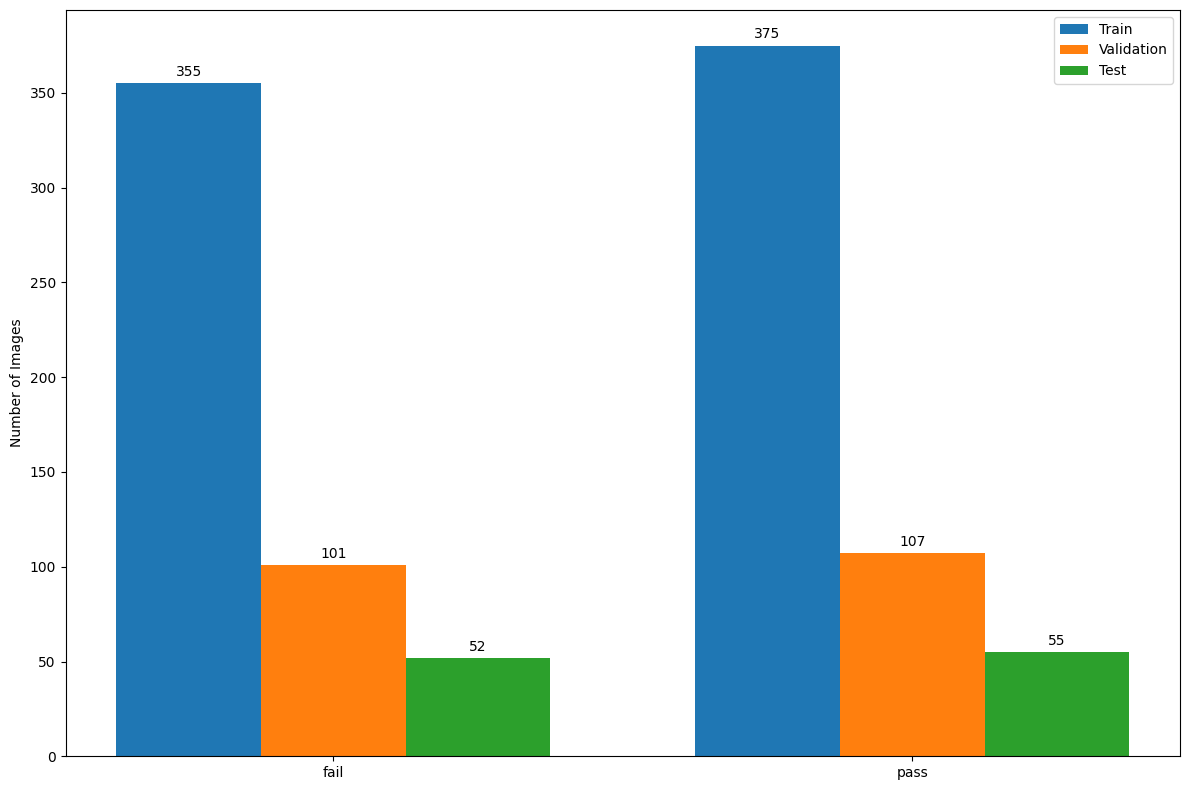

In [4]:
visualize_data(train_dir, val_dir, test_dir)

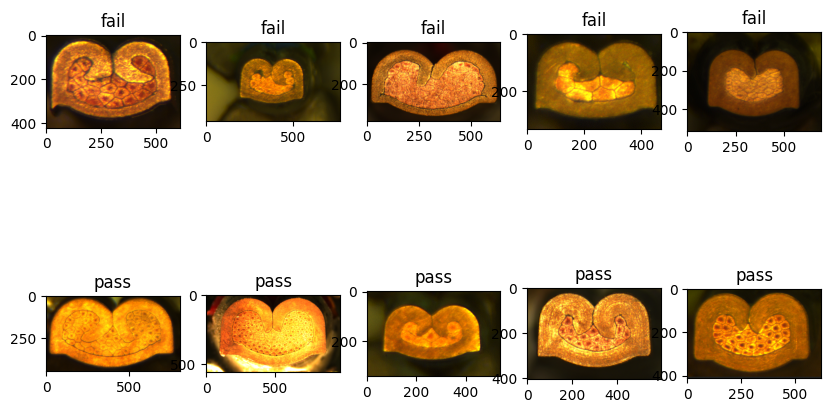

In [5]:
# Define the paths to the train directories for the "fail" and "pass" classes
fail_train_dir = os.path.join(data_dir, "train", "fail")
pass_train_dir = os.path.join(data_dir, "train", "pass")

# Define the paths to a few images from each class
fail_images = [os.path.join(fail_train_dir, f) for f in os.listdir(fail_train_dir)[:5]]
pass_images = [os.path.join(pass_train_dir, f) for f in os.listdir(pass_train_dir)[:5]]

# Plot the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 6))

for i, image_path in enumerate(fail_images):
    ax = axes[0, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("fail")

for i, image_path in enumerate(pass_images):
    ax = axes[1, i]
    img = plt.imread(image_path)
    ax.imshow(img)
    ax.set_title("pass")

plt.show()

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
    rotation_range=20,
    brightness_range=[0.8, 1.2],
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2 
    )

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["fail", "pass"],
    seed=42,
    shuffle=True
    )

Found 404 images belonging to 2 classes.


In [4]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["fail", "pass"],
    seed=42,
    shuffle=True
    )

Found 109 images belonging to 2 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode="binary",
    classes=["fail", "pass"],
    shuffle = False,
    seed=42
    )

Found 67 images belonging to 2 classes.


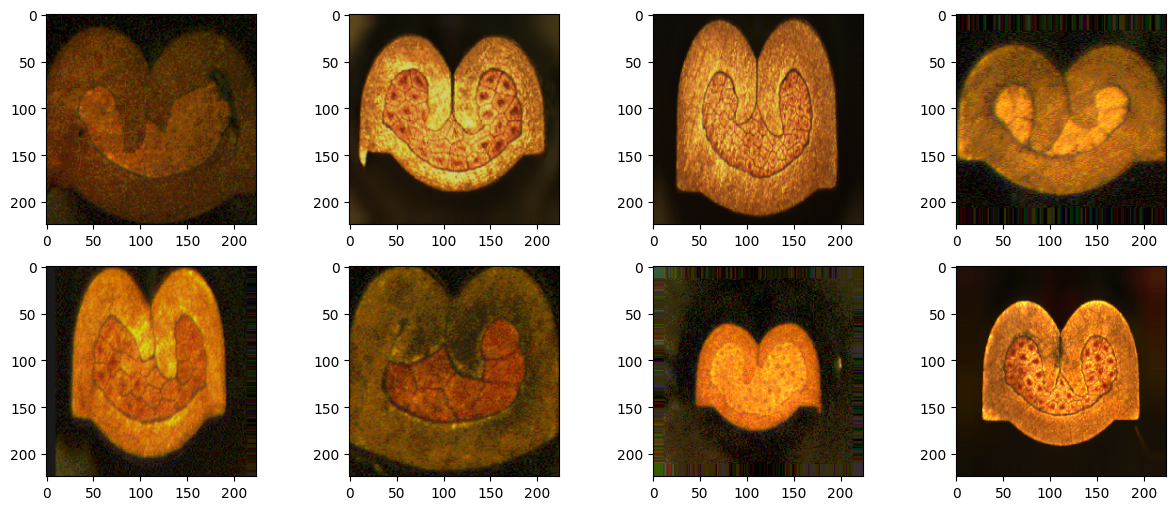

In [9]:
# Get a batch of images from the generator
img_batch, _ = train_data.next()

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(img_batch[i])
    ax.axis('on')
    
plt.show()

In [10]:
class_names = train_data.class_indices
class_names

{'fail': 0, 'pass': 1}

In [11]:
# Get the class labels from the data generator
labels = train_data.classes

# Calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_data.classes), y=labels)

# Convert the class weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))

In [12]:
class_weight_dict

{0: 0.8898678414096917, 1: 1.1412429378531073}

In [15]:
base_model = VGG19(
        weights='imagenet', # Load pre-trained weights from the ImageNet dataset
        include_top=False, # Set to False to exclude the top fully connected layers from the model
        input_shape=(img_width, img_height, 3) # The input shape of the images
    )

gmp = GlobalAveragePooling2D()(base_model.output)

output = Dense(1, activation='sigmoid')(gmp)

model = Model(base_model.input, outputs=output)

In [16]:
for layer in base_model.layers:
    layer.trainable = False

In [17]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])    

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fc21a1b2940>,input_1,False
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21cd73a30>,block1_conv1,False
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21a219850>,block1_conv2,False
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc21a6ae040>,block1_pool,False
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21a2de820>,block2_conv1,False
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21a384d90>,block2_conv2,False
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc21a388c10>,block2_pool,False
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21a383d00>,block3_conv1,False
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21a320a00>,block3_conv2,False
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21a320f40>,block3_conv3,False


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
recall = Recall()
precision = Precision()

In [20]:
optimizer = SGD(learning_rate=0.01, decay=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [21]:
early_stopping_cb = EarlyStopping(patience=3,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [22]:
EPOCHS = 10

num_workers = multiprocessing.cpu_count()
#workers=num_workers,
#use_multiprocessing=True,
#class_weight=class_weight_dict
history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb],
                      class_weight=class_weight_dict
                  )

Epoch 1/10


2023-04-30 06:58:31.338332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - ETA: 0s - loss: 0.7206 - accuracy: 0.5375 - recall: 0.5943 - precision: 0.4771

2023-04-30 06:59:26.484338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - 69s 1s/step - loss: 0.7206 - accuracy: 0.5375 - recall: 0.5943 - precision: 0.4771 - val_loss: 0.6530 - val_accuracy: 0.6250 - val_recall: 0.7442 - val_precision: 0.5333
Epoch 2/10
50/50 [==============================] - 65s 1s/step - loss: 0.6819 - accuracy: 0.5631 - recall: 0.6149 - precision: 0.5023 - val_loss: 0.6987 - val_accuracy: 0.5000 - val_recall: 0.9767 - val_precision: 0.4516
Epoch 3/10
50/50 [==============================] - 65s 1s/step - loss: 0.6573 - accuracy: 0.5909 - recall: 0.5690 - precision: 0.5323 - val_loss: 0.6098 - val_accuracy: 0.6538 - val_recall: 0.2273 - val_precision: 0.8333
Epoch 4/10
50/50 [==============================] - 64s 1s/step - loss: 0.6398 - accuracy: 0.6338 - recall: 0.6590 - precision: 0.5700 - val_loss: 0.6671 - val_accuracy: 0.5577 - val_recall: 0.9767 - val_precision: 0.4828
Epoch 5/10
50/50 [==============================] - 63s 1s/step - loss: 0.6377 - accuracy: 0.6162 - recall: 0.6839 - precis

In [23]:
len(base_model.layers)

22

In [25]:
for layer in base_model.layers:
  layer.trainable = True

In [26]:
optimizer = SGD(learning_rate=0.001, decay=0.01, momentum=0.9)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy', recall, precision])

In [27]:
pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
df = pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 
df 

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x7fc21a1b2940>,input_1,True
1,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21cd73a30>,block1_conv1,True
2,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21a219850>,block1_conv2,True
3,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc21a6ae040>,block1_pool,True
4,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21a2de820>,block2_conv1,True
5,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21a384d90>,block2_conv2,True
6,<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fc21a388c10>,block2_pool,True
7,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21a383d00>,block3_conv1,True
8,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21a320a00>,block3_conv2,True
9,<keras.layers.convolutional.conv2d.Conv2D object at 0x7fc21a320f40>,block3_conv3,True


In [28]:
df['Layer Trainable'].value_counts()[True]

24

In [29]:
early_stopping_cb = EarlyStopping(patience=10,
                                  restore_best_weights=True,
                                  monitor='val_loss',
                                  mode='min')

In [30]:
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [31]:
checkpoint_cb = ModelCheckpoint('model_4.h5',
                                save_best_only=True,
                                monitor='val_loss',
                                mode='min')

In [32]:
csv_logger = CSVLogger('training_log4.csv')

In [33]:
EPOCHS = 100

num_workers = multiprocessing.cpu_count()

history = model.fit(train_data, 
                      validation_data=val_data,
                      epochs=EPOCHS,
                      steps_per_epoch=(train_data.n//batch_size),
                      validation_steps=(val_data.n//batch_size),
                      callbacks=[early_stopping_cb,checkpoint_cb, reduce_lr_cb, csv_logger],
                      class_weight=class_weight_dict
                   )

Epoch 1/100


2023-04-30 07:09:24.891887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.5960 - recall: 0.4977 - precision: 0.5684

2023-04-30 07:15:17.298308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


50/50 [==============================] - 366s 7s/step - loss: 0.6853 - accuracy: 0.5960 - recall: 0.4977 - precision: 0.5684 - val_loss: 0.5969 - val_accuracy: 0.6442 - val_recall: 0.2143 - val_precision: 0.6923 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 364s 7s/step - loss: 0.5699 - accuracy: 0.6768 - recall: 0.7356 - precision: 0.6095 - val_loss: 0.4412 - val_accuracy: 0.8365 - val_recall: 0.8043 - val_precision: 0.8222 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 361s 7s/step - loss: 0.5076 - accuracy: 0.7273 - recall: 0.7399 - precision: 0.6702 - val_loss: 0.4431 - val_accuracy: 0.7788 - val_recall: 0.9778 - val_precision: 0.6667 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 361s 7s/step - loss: 0.4995 - accuracy: 0.7601 - recall: 0.7759 - precision: 0.7068 - val_loss: 0.4411 - val_accuracy: 0.8077 - val_recall: 0.7273 - val_precision: 0.8000 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 360s 7s/ste

In [34]:
def visualize_training_results(results):
    history = results.history
    
    # Find the epoch where validation accuracy was highest
    best_epoch = np.argmin(history['val_loss'])
    
    for m in ['loss', 'accuracy', 'precision', 'recall']:
        plt.figure(figsize=(15,5))
        plt.plot(history[m], label='Training', marker='o', color='blue')
        plt.plot(history[f'val_{m}'], label='Validation', marker='o', color='red')
        plt.axvline(x=best_epoch, linestyle='--', color='green', label='Best epoch')
        plt.xlabel('Epochs')
        plt.legend()
        plt.title(m.title())
    
    plt.show()

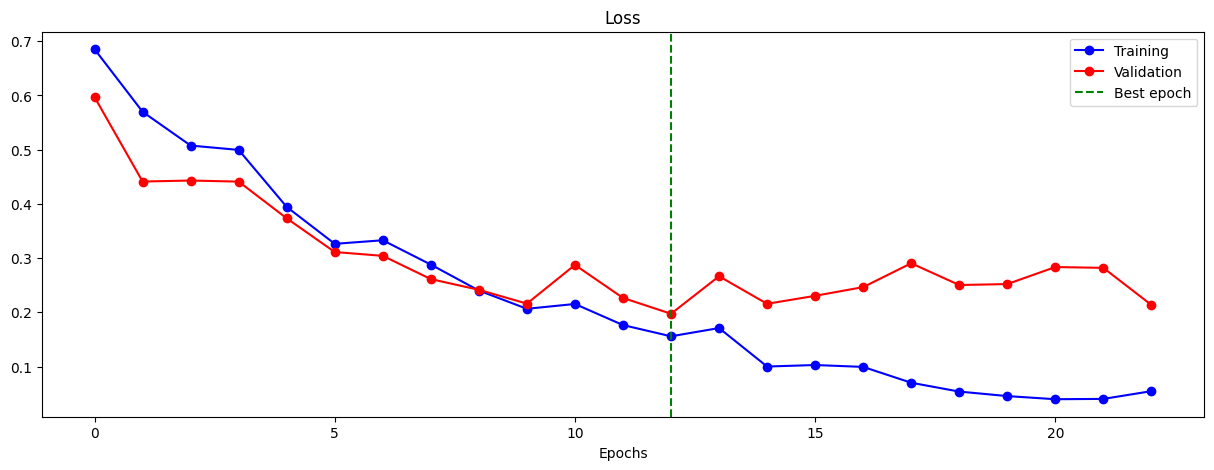

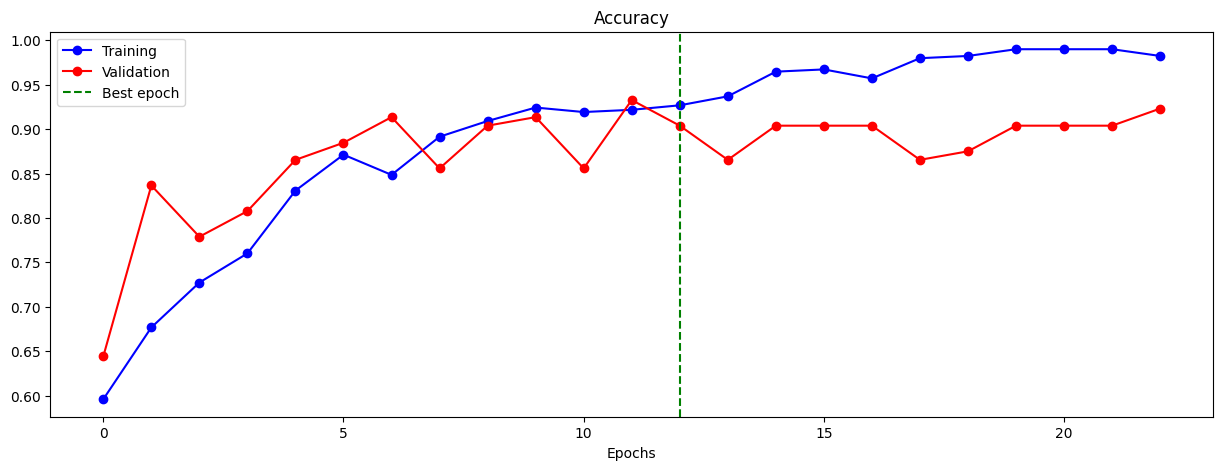

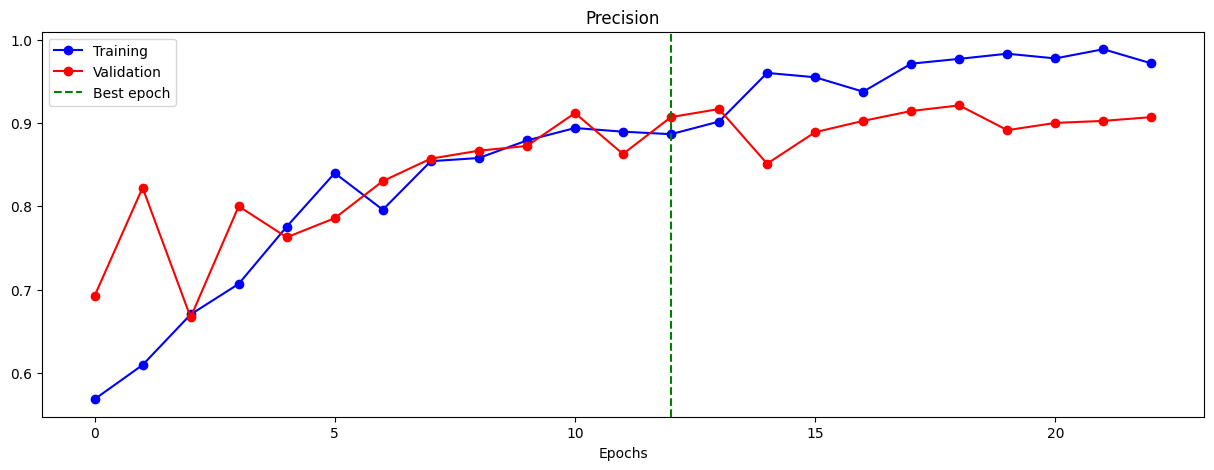

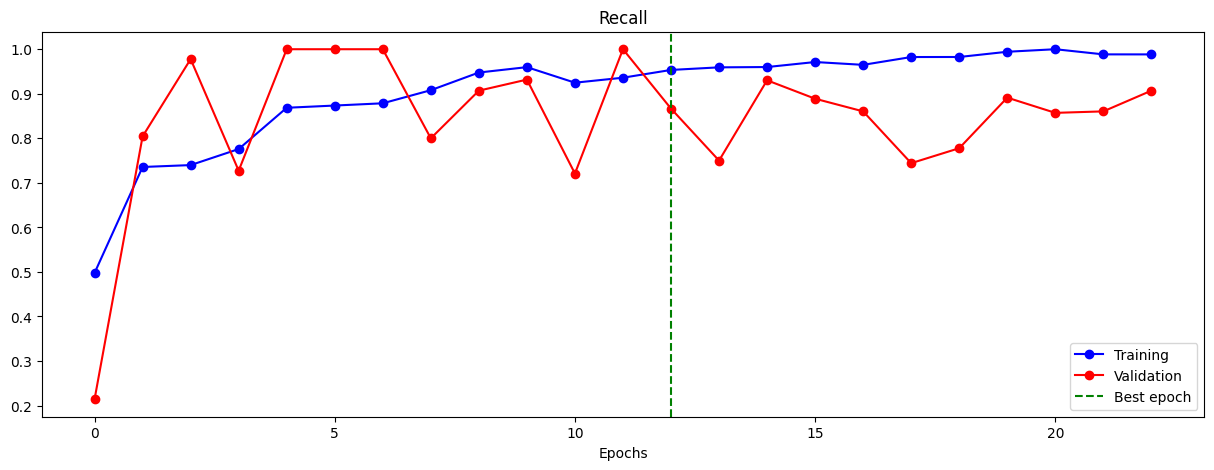

In [35]:
visualize_training_results(history)

In [6]:
def plot_metrics(model, test_data):
    # Get the predicted labels and true labels
    y_pred = model.predict(test_data)
    y_pred = y_pred > 0.5
    y_true = test_data.labels

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax1)
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix')
    ax1.xaxis.set_ticklabels(['NO OK', 'OK'])
    ax1.yaxis.set_ticklabels(['NO OK', 'OK'])

    # Calculate the true positive rate (TPR) and false positive rate (FPR) at different thresholds
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calculate the area under the ROC curve (AUC)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    ax2.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], linestyle='--', label='Random guessing')
 
    ax2.set_xlabel('False Positive Rate (FPR)')
    ax2.set_ylabel('True Positive Rate (TPR)')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    plt.show()
    
    # Generate the classification report
    report = classification_report(y_true, y_pred)
    # Print the report
    print(report)


2023-04-30 14:59:59.717329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9/9 [==============================] - 10s 1s/step


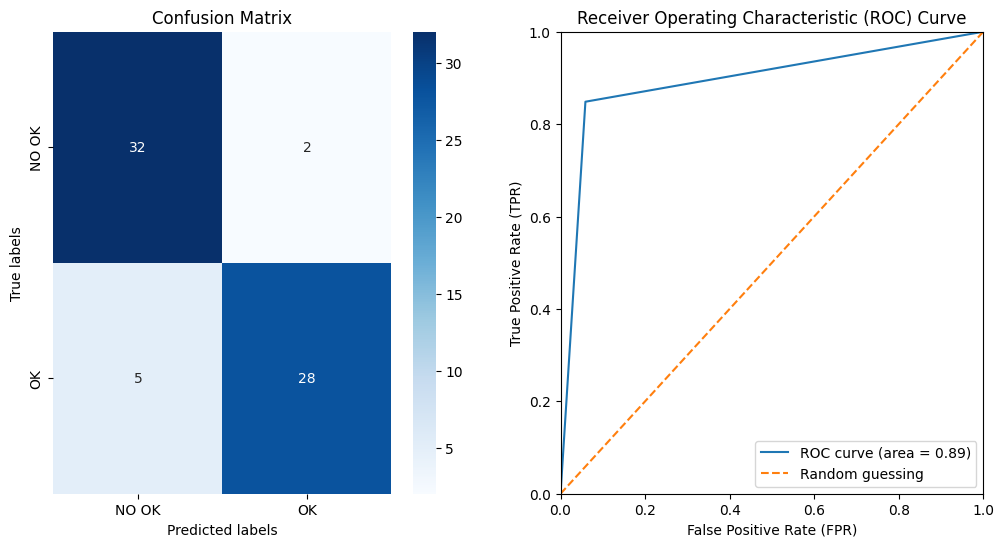

              precision    recall  f1-score   support

           0       0.86      0.94      0.90        34
           1       0.93      0.85      0.89        33

    accuracy                           0.90        67
   macro avg       0.90      0.89      0.90        67
weighted avg       0.90      0.90      0.90        67



In [37]:
plot_metrics(model, test_data)

In [38]:
# Print the metrics of the best epoch
best_epoch = np.argmin(history.history['val_loss'])
print("Best epoch: ", best_epoch)
print("Best loss: ", history.history['loss'][best_epoch])
print("Best accuracy: ", history.history['accuracy'][best_epoch])
print("Best recall: ", history.history['recall'][best_epoch])
print("Best precision: ", history.history['precision'][best_epoch])
print("Best val_loss: ", history.history['val_loss'][best_epoch])
print("Best val_accuracy: ", history.history['val_accuracy'][best_epoch])
print("Best val_recall: ", history.history['val_recall'][best_epoch])
print("Best val_precision: ", history.history['val_precision'][best_epoch])

Best epoch:  12
Best loss:  0.15578670799732208
Best accuracy:  0.9267676472663879
Best recall:  0.9534883499145508
Best precision:  0.8864864706993103
Best val_loss:  0.1973249912261963
Best val_accuracy:  0.9038461446762085
Best val_recall:  0.8666666746139526
Best val_precision:  0.9069767594337463


In [7]:

from keras.models import load_model
saved_model = load_model('model_4.h5')

2023-05-03 18:59:44.157105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


9/9 [==============================] - 9s 953ms/step


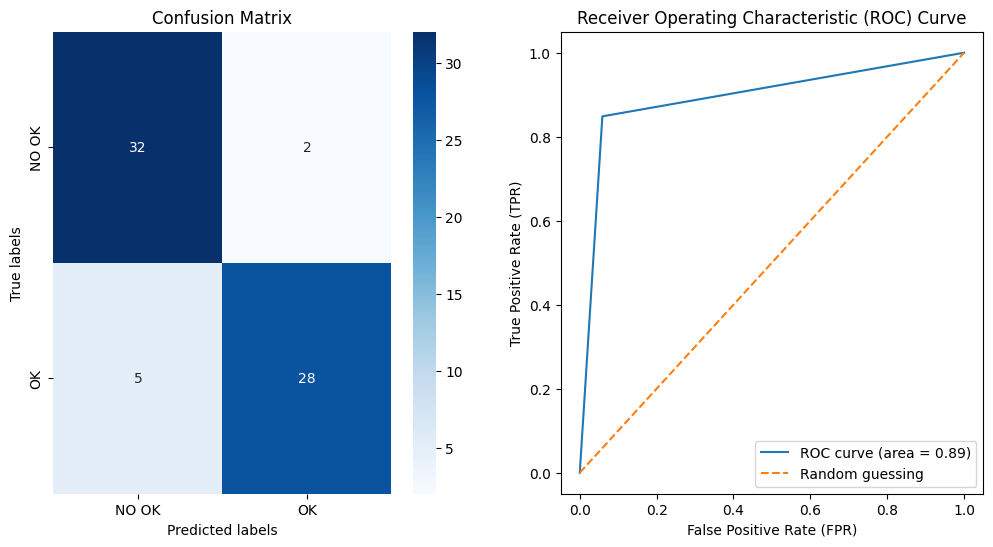

              precision    recall  f1-score   support

           0       0.86      0.94      0.90        34
           1       0.93      0.85      0.89        33

    accuracy                           0.90        67
   macro avg       0.90      0.89      0.90        67
weighted avg       0.90      0.90      0.90        67



In [8]:
plot_metrics(saved_model,test_data)